In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB

import mglearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_curve


## Leitura dos dados

In [2]:
fN = '/Users/anaso/Documents/AA/AA-22-23/Trabalho Final/imdbFull.p'

D = pickle.load(open(fN, 'rb'))

nDocs = 5000

corpus = D.data[:nDocs]
y = D.target[:nDocs]

y = [1 if val>5 else 0 for val in y]

In [3]:
print("Número de documentos no corpus:", len(corpus))
print("Número de classes:", len(np.bincount(y)))
print("Distribuição de amostras por classe:", np.bincount(y))

Número de documentos no corpus: 5000
Número de classes: 2
Distribuição de amostras por classe: [2496 2504]


## Limpeza de dados

In [4]:
corpus = [critica.replace("<br />", " ") for critica in corpus]
corpus = [" ".join((palavra if palavra not in stop_words else " ") for palavra in critica.split()) for critica in corpus]
corpus = [" ".join(lemma.lemmatize(palavra) for palavra in critica.split()) for critica in corpus]

## Divisão dos dados em teste, validação e treino 

In [5]:
corpus_treino, corpus_teste, y_treino, y_teste = train_test_split(corpus, y, test_size=1/3, shuffle=True, stratify=y)
_, corpus_validacao, _, y_validacao = train_test_split(corpus_treino, y_treino, test_size=1/2, shuffle=True, stratify=y_treino)

In [6]:
print("Treino (Treino+Validação)")
print("- Número de documentos para treino: ", len(corpus_treino))
print("- Número de avaliações para treino: ", len(y_treino))

print("\nValidação")
print("- Número de documentos para validação: ", len(corpus_validacao))
print("- Número de avaliações para validação: ", len(y_validacao))

print("\nTeste")
print("- Número de documentos para teste: ", len(corpus_teste))
print("- Número de avaliações para teste: ", len(y_teste))

Treino (Treino+Validação)
- Número de documentos para treino:  3333
- Número de avaliações para treino:  3333

Validação
- Número de documentos para validação:  1667
- Número de avaliações para validação:  1667

Teste
- Número de documentos para teste:  1667
- Número de avaliações para teste:  1667


## Extração de Caracteristicas

In [7]:
tf = TfidfVectorizer(min_df=3, max_df=0.75, ngram_range=(1,3), token_pattern=r'\b\w{3,}\b').fit(corpus_treino) 

corpus_treino_p = tf.transform(corpus_treino)
corpus_validacao_p = tf.transform(corpus_validacao)
corpus_teste_p = tf.transform(corpus_teste)

st = StandardScaler(with_mean=False).fit(corpus_treino_p)

corpus_treino_s = st.transform(corpus_treino_p)
corpus_validacao_s = st.transform(corpus_validacao_p)
corpus_teste_s = st.transform(corpus_teste_p)


# Classificador LogisticRegression

- Resultados sem parametrização do classificador

In [8]:
scores = cross_val_score(LogisticRegression(max_iter=5000), corpus_treino_s, y_treino, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.84


- Ajuste dos hiperparametros

In [9]:
param_grid = {'penalty': ['l1', 'l2'], 
            'tol': [1e-3, 1e-4, 1e-5], 
            'C': [0.01, 0.1, 1, 10, 100], 
            'solver': ['liblinear', 'saga'],
             'multi_class': ['ovr', 'auto']}

grid = GridSearchCV(LogisticRegression(max_iter=5000, random_state=42), param_grid, cv=3, verbose=3)
grid.fit(corpus_validacao_s, y_validacao)

Fitting 3 folds for each of 120 candidates, totalling 360 fits
[CV 1/3] END C=0.01, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.001;, score=0.635 total time=   0.0s
[CV 2/3] END C=0.01, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.001;, score=0.615 total time=   0.0s
[CV 3/3] END C=0.01, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.001;, score=0.634 total time=   0.0s
[CV 1/3] END C=0.01, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.0001;, score=0.635 total time=   0.0s
[CV 2/3] END C=0.01, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.0001;, score=0.615 total time=   0.0s
[CV 3/3] END C=0.01, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.0001;, score=0.634 total time=   0.0s
[CV 1/3] END C=0.01, multi_class=ovr, penalty=l1, solver=liblinear, tol=1e-05;, score=0.635 total time=   0.0s
[CV 2/3] END C=0.01, multi_class=ovr, penalty=l1, solver=liblinear, tol=1e-05;, score=0.615 total time=   0.0s
[CV 3/3] END C=0.01, multi_class=ovr, penalty=

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.01, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.682 total time=  12.9s
[CV 3/3] END C=0.01, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.668 total time=   2.1s
[CV 1/3] END C=0.01, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.831 total time=   0.0s
[CV 2/3] END C=0.01, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.01, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.01, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.01, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.01, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.01, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.829 total time=   0.0s
[CV 2/3]

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.01, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.682 total time=  12.6s
[CV 3/3] END C=0.01, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.668 total time=   2.2s
[CV 1/3] END C=0.01, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.831 total time=   0.0s
[CV 2/3] END C=0.01, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.01, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.01, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.829 total time=   0.0s
[CV 2/3] END C=0.01, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.01, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.01, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.829 total time=   0.0s

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.808 total time=  21.6s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.782 total time=  22.6s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.793 total time=  22.3s
[CV 1/3] END C=0.1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.824 total time=   0.0s
[CV 2/3] END C=0.1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.838 total time=   0.0s
[CV 1/3] END C=0.1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.826 total time=   0.0s
[CV 2/3] END C=0.1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.1, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.826 total time=   0.0s
[CV 2/3] END C=0.1, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.820 total time=   0.0s
[CV 3/3] END

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=0.1, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.808 total time=  21.8s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=0.1, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.782 total time=  22.2s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=0.1, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.793 total time=  21.8s
[CV 1/3] END C=0.1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.824 total time=   0.0s
[CV 2/3] END C=0.1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.838 total time=   0.0s
[CV 1/3] END C=0.1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.826 total time=   0.0s
[CV 2/3] END C=0.1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 3/3] END C=0.1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.840 total time=   0.0s
[CV 1/3] END C=0.1, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.826 total time=   0.0s
[CV 2/3] END C=0.1, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.820 total time=   0.0s
[CV

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, multi_class=ovr, penalty=l1, solver=saga, tol=0.0001;, score=0.842 total time=  45.1s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, multi_class=ovr, penalty=l1, solver=saga, tol=0.0001;, score=0.808 total time=  44.4s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, multi_class=ovr, penalty=l1, solver=saga, tol=0.0001;, score=0.829 total time=  45.0s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.842 total time=  44.6s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.808 total time=  44.5s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.829 total time=  44.1s
[CV 1/3] END C=1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 2/3] END C=1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 3/3] END C=1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.822 total time=   0.0s
[CV 2/3] END C=1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.818 total time=   0.0s
[CV 3/3] END C=1, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.838 total time=   0.0s
[CV 1/3] END C=1, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.824 total time=   0.0s
[CV 2/3] END C=1, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.817 total time=   0.0s
[CV 3/3] END C=1, multi_class=

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, multi_class=auto, penalty=l1, solver=saga, tol=0.0001;, score=0.842 total time=  46.0s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, multi_class=auto, penalty=l1, solver=saga, tol=0.0001;, score=0.808 total time=  48.7s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, multi_class=auto, penalty=l1, solver=saga, tol=0.0001;, score=0.829 total time=  45.4s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=1, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.842 total time=  45.0s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=1, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.808 total time=  45.3s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=1, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.829 total time=  45.4s
[CV 1/3] END C=1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 2/3] END C=1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 3/3] END C=1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.834 total time=   0.0s
[CV 1/3] END C=1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.822 total time=   0.0s
[CV 2/3] END C=1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.818 total time=   0.0s
[CV 3/3] END C=1, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.838 total time=   0.0s
[CV 1/3] END C=1, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.824 total time=   0.0s
[CV 2/3] END C=1, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.817 total time=   0.0s
[CV 3/3] END C=1, mul

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, multi_class=ovr, penalty=l1, solver=saga, tol=0.0001;, score=0.858 total time= 2.0min
[CV 2/3] END C=10, multi_class=ovr, penalty=l1, solver=saga, tol=0.0001;, score=0.811 total time= 2.0min
[CV 3/3] END C=10, multi_class=ovr, penalty=l1, solver=saga, tol=0.0001;, score=0.854 total time= 2.0min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.858 total time= 2.0min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.815 total time= 2.0min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.852 total time= 2.0min
[CV 1/3] END C=10, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 2/3] END C=10, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.822 total time=   0.0s
[CV 3/3] END C=10, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.834 total time=   0.0s
[CV 1/3] END C=10, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 2/3] END C=10, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 3/3] END C=10, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.836 total time=   0.0s
[CV 1/3] END C=10, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.820 total time=   0.0s
[CV 2/3] END C=10, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.818 total time=   0.0s
[CV 3/3] END C=10, mu

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, multi_class=ovr, penalty=l2, solver=saga, tol=1e-05;, score=0.824 total time=  10.0s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, multi_class=ovr, penalty=l2, solver=saga, tol=1e-05;, score=0.820 total time=  10.0s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, multi_class=ovr, penalty=l2, solver=saga, tol=1e-05;, score=0.840 total time=  10.0s
[CV 1/3] END C=10, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001;, score=0.826 total time=   0.0s
[CV 2/3] END C=10, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001;, score=0.802 total time=   0.0s
[CV 3/3] END C=10, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001;, score=0.829 total time=   0.0s
[CV 1/3] END C=10, multi_class=auto, penalty=l1, solver=liblinear, tol=0.0001;, score=0.831 total time=   0.0s
[CV 2/3] END C=10, multi_class=auto, penalty=l1, solver=liblinear, tol=0.0001;, score=0.788 total time=   0.0s
[CV 3/3] END C=10, multi_class=auto, penalty=l1, solver=liblinear, tol=0.0001;, score=0.822 total time=   0.0s
[CV 1/3] END C=10, multi_class=auto, penalty=l1, solver=liblinear, tol=1e-05;, score=0.809 total time=   0.0s
[CV 2/3] END C=10, multi_class=auto, penalty=l1, solver=liblinear, tol=1e-05;, score=0.782 total time=   0.0s
[CV 3/3] END 

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, multi_class=auto, penalty=l1, solver=saga, tol=0.0001;, score=0.858 total time= 2.0min
[CV 2/3] END C=10, multi_class=auto, penalty=l1, solver=saga, tol=0.0001;, score=0.811 total time= 2.0min
[CV 3/3] END C=10, multi_class=auto, penalty=l1, solver=saga, tol=0.0001;, score=0.854 total time= 2.0min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.858 total time= 2.1min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.815 total time= 2.1min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.852 total time= 2.1min
[CV 1/3] END C=10, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 2/3] END C=10, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.822 total time=   0.0s
[CV 3/3] END C=10, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.834 total time=   0.0s
[CV 1/3] END C=10, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 2/3] END C=10, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 3/3] END C=10, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.836 total time=   0.0s
[CV 1/3] END C=10, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.820 total time=   0.0s
[CV 2/3] END C=10, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.818 total time=   0.0s
[CV 3/3] END

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=10, multi_class=auto, penalty=l2, solver=saga, tol=1e-05;, score=0.824 total time=  10.2s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=10, multi_class=auto, penalty=l2, solver=saga, tol=1e-05;, score=0.820 total time=  10.1s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=10, multi_class=auto, penalty=l2, solver=saga, tol=1e-05;, score=0.840 total time=   9.8s
[CV 1/3] END C=100, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.001;, score=0.777 total time=   0.0s
[CV 2/3] END C=100, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.001;, score=0.763 total time=   0.0s
[CV 3/3] END C=100, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.001;, score=0.775 total time=   0.0s
[CV 1/3] END C=100, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.0001;, score=0.835 total time=   0.0s
[CV 2/3] END C=100, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.0001;, score=0.797 total time=   0.0s
[CV 3/3] END C=100, multi_class=ovr, penalty=l1, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 1/3] END C=100, multi_class=ovr, penalty=l1, solver=liblinear, tol=1e-05;, score=0.827 total time=   0.0s
[CV 2/3] END C=100, multi_class=ovr, penalty=l1, solver=liblinear, tol=1e-05;, score=0.795 total time=   0.0s
[CV 3/3] END

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.820 total time= 5.1min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.817 total time= 5.1min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, multi_class=ovr, penalty=l1, solver=saga, tol=1e-05;, score=0.852 total time= 5.2min
[CV 1/3] END C=100, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 2/3] END C=100, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.822 total time=   0.0s
[CV 3/3] END C=100, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.001;, score=0.834 total time=   0.0s
[CV 1/3] END C=100, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.818 total time=   0.0s
[CV 2/3] END C=100, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 3/3] END C=100, multi_class=ovr, penalty=l2, solver=liblinear, tol=0.0001;, score=0.834 total time=   0.0s
[CV 1/3] END C=100, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.820 total time=   0.0s
[CV 2/3] END C=100, multi_class=ovr, penalty=l2, solver=liblinear, tol=1e-05;, score=0.818 total time=   0.0s
[CV 3/3] END

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, multi_class=ovr, penalty=l2, solver=saga, tol=1e-05;, score=0.824 total time=  10.5s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, multi_class=ovr, penalty=l2, solver=saga, tol=1e-05;, score=0.820 total time=  10.3s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, multi_class=ovr, penalty=l2, solver=saga, tol=1e-05;, score=0.840 total time=  10.6s
[CV 1/3] END C=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001;, score=0.777 total time=   0.0s
[CV 2/3] END C=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001;, score=0.763 total time=   0.0s
[CV 3/3] END C=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.001;, score=0.775 total time=   0.0s
[CV 1/3] END C=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.0001;, score=0.835 total time=   0.0s
[CV 2/3] END C=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.0001;, score=0.797 total time=   0.0s
[CV 3/3] END C=100, multi_class=auto, penalty=l1, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 1/3] END C=100, multi_class=auto, penalty=l1, solver=liblinear, tol=1e-05;, score=0.827 total time=   0.0s
[CV 2/3] END C=100, multi_class=auto, penalty=l1, solver=liblinear, tol=1e-05;, score=0.795 total time=   0.0s
[CV 

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.820 total time= 5.0min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.817 total time= 5.3min


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, multi_class=auto, penalty=l1, solver=saga, tol=1e-05;, score=0.852 total time= 5.2min
[CV 1/3] END C=100, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.820 total time=   0.0s
[CV 2/3] END C=100, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.822 total time=   0.0s
[CV 3/3] END C=100, multi_class=auto, penalty=l2, solver=liblinear, tol=0.001;, score=0.834 total time=   0.0s
[CV 1/3] END C=100, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.818 total time=   0.0s
[CV 2/3] END C=100, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.820 total time=   0.0s
[CV 3/3] END C=100, multi_class=auto, penalty=l2, solver=liblinear, tol=0.0001;, score=0.834 total time=   0.0s
[CV 1/3] END C=100, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.820 total time=   0.0s
[CV 2/3] END C=100, multi_class=auto, penalty=l2, solver=liblinear, tol=1e-05;, score=0.818 total time=   0.0s
[CV

C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END C=100, multi_class=auto, penalty=l2, solver=saga, tol=1e-05;, score=0.824 total time=  11.0s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END C=100, multi_class=auto, penalty=l2, solver=saga, tol=1e-05;, score=0.820 total time=  11.3s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END C=100, multi_class=auto, penalty=l2, solver=saga, tol=1e-05;, score=0.840 total time=  10.7s


C:\Users\anaso\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=5000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'multi_class': ['ovr', 'auto'],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga'],
                         'tol': [0.001, 0.0001, 1e-05]},
             verbose=3)

In [10]:
print(grid.best_estimator_)

LogisticRegression(C=10, max_iter=5000, multi_class='ovr', penalty='l1',
                   random_state=42, solver='saga', tol=1e-05)


- Treino

In [11]:
lr = LogisticRegression(max_iter=5000, C=10, penalty='l2', solver='liblinear', tol=1e-3).fit(corpus_treino_s, y_treino)

lr_y_treino_e = lr.predict(corpus_treino_s)

print("Score treino:", lr.score(corpus_treino_s, y_treino))


Score treino: 1.0


- Teste e Avaliação

In [12]:
lr_fpr, lr_tpr, _ = roc_curve(y_teste, lr.predict_proba(corpus_teste_s)[:, 1])

lr_y_teste_e = lr.predict(corpus_teste_s)


Treino
Número de erros: 0
Precisão:  1.0


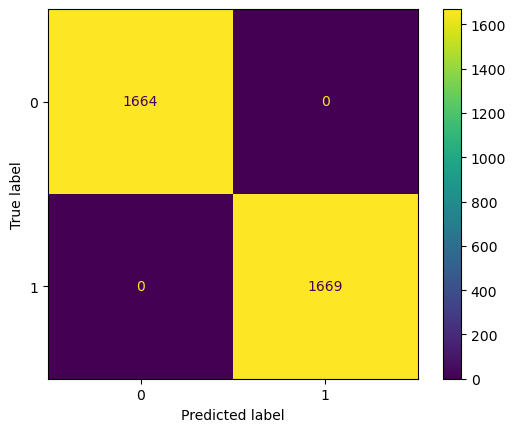

In [42]:
print("Treino")

erros_treino_lr = np.round(np.sum(y_treino != lr_y_treino_e), 3)
precisao_treino_lr = np.round(accuracy_score(y_treino,lr_y_treino_e), 3)
matriz_confusao = confusion_matrix(y_treino, lr_y_treino_e)
tn_treino_lr, fp_treino_lr, fn_treino_lr, tp_treino_lr = matriz_confusao.ravel()

print("Número de erros:", erros_treino_lr)
print("Precisão: ", precisao_treino_lr)
disp = ConfusionMatrixDisplay(matriz_confusao)
disp.plot()
plt.show()

Teste
Número de erros: 259
Precisão:  0.845


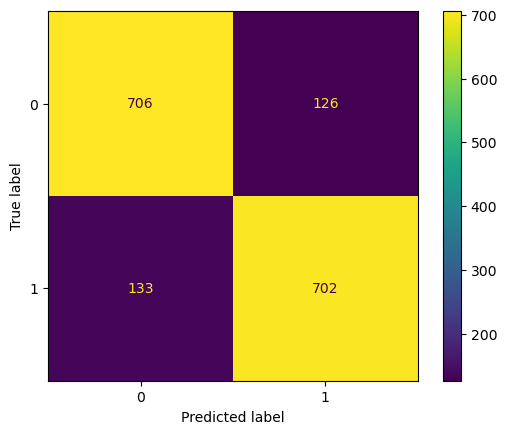

In [43]:
print("Teste")

erros_teste_lr = np.round(np.sum(y_teste != lr_y_teste_e), 3)
precisao_teste_lr = np.round(accuracy_score(y_teste,lr_y_teste_e), 3)
matriz_confusao = confusion_matrix(y_teste, lr_y_teste_e)
tn_teste_lr, fp_teste_lr, fn_teste_lr, tp_teste_lr = matriz_confusao.ravel()

tpr_teste_lr = tp_teste_lr/(tp_teste_lr + fp_teste_lr)
fpr_teste_lr = fp_teste_lr/(fp_teste_lr + tn_teste_lr)

print("Número de erros:", erros_teste_lr)
print("Precisão: ", precisao_teste_lr)
disp = ConfusionMatrixDisplay(matriz_confusao, display_labels=np.unique(y_teste))
disp.plot()
plt.show()

# Classificador LinearSVC

- Resultados sem paramtrização do classificador

In [15]:
scores = cross_val_score(LinearSVC(max_iter=5000), corpus_treino_p, y_treino, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.86


- Ajuste dos parametros

In [16]:
param_grid = {'penalty': ['l2'], 
              'loss': ['hinge', 'squared_hinge'],
            'tol': [1e-3, 1e-4, 1e-5, 1e-6], 
            'C': [0.01, 0.1, 1, 10, 100], 
             'multi_class': ['ovr']}

grid = GridSearchCV(LinearSVC(max_iter=5000, random_state=42), param_grid, cv=3, verbose=3)
grid.fit(corpus_validacao_p, y_validacao)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV 1/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=0.001;, score=0.820 total time=   0.0s
[CV 2/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=0.001;, score=0.581 total time=   0.0s
[CV 3/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=0.001;, score=0.690 total time=   0.0s
[CV 1/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=0.0001;, score=0.820 total time=   0.0s
[CV 2/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=0.0001;, score=0.581 total time=   0.0s
[CV 3/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=0.0001;, score=0.690 total time=   0.0s
[CV 1/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=1e-05;, score=0.820 total time=   0.0s
[CV 2/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=1e-05;, score=0.581 total time=   0.0s
[CV 3/3] END C=0.01, loss=hinge, multi_class=ovr, penalty=l2, tol=1e-05;, score=0.690 total tim

[CV 3/3] END C=10, loss=hinge, multi_class=ovr, penalty=l2, tol=1e-05;, score=0.834 total time=   0.0s
[CV 1/3] END C=10, loss=hinge, multi_class=ovr, penalty=l2, tol=1e-06;, score=0.847 total time=   0.0s
[CV 2/3] END C=10, loss=hinge, multi_class=ovr, penalty=l2, tol=1e-06;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, loss=hinge, multi_class=ovr, penalty=l2, tol=1e-06;, score=0.834 total time=   0.0s
[CV 1/3] END C=10, loss=squared_hinge, multi_class=ovr, penalty=l2, tol=0.001;, score=0.851 total time=   0.0s
[CV 2/3] END C=10, loss=squared_hinge, multi_class=ovr, penalty=l2, tol=0.001;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, loss=squared_hinge, multi_class=ovr, penalty=l2, tol=0.001;, score=0.834 total time=   0.0s
[CV 1/3] END C=10, loss=squared_hinge, multi_class=ovr, penalty=l2, tol=0.0001;, score=0.851 total time=   0.0s
[CV 2/3] END C=10, loss=squared_hinge, multi_class=ovr, penalty=l2, tol=0.0001;, score=0.842 total time=   0.0s
[CV 3/3] END C=10, loss=squared

GridSearchCV(cv=3, estimator=LinearSVC(max_iter=5000, random_state=42),
             param_grid={'C': [0.01, 0.1, 1, 10, 100],
                         'loss': ['hinge', 'squared_hinge'],
                         'multi_class': ['ovr'], 'penalty': ['l2'],
                         'tol': [0.001, 0.0001, 1e-05, 1e-06]},
             verbose=3)

In [17]:
print("Best estimator: ", grid.best_estimator_)

Best estimator:  LinearSVC(C=1, max_iter=5000, random_state=42, tol=0.001)


- Treino

In [18]:
lSvm = LinearSVC(C=1, loss='hinge', max_iter=5000, random_state=42, tol=1e-4).fit(corpus_treino_p, y_treino)

lSvm_y_treino_e = lSvm.predict(corpus_treino_p)
print("Score treino:", lSvm.score(corpus_treino_p, y_treino))

Score treino: 0.9921992199219922


- Teste e Avaliação

In [19]:
lSvm_fpr, lSvm_tpr, _ = roc_curve(y_teste, lSvm.decision_function(corpus_teste_p))

lSvm_y_teste_e = lSvm.predict(corpus_teste_p)

Treino
Número de erros: 26
Precisão:  0.992


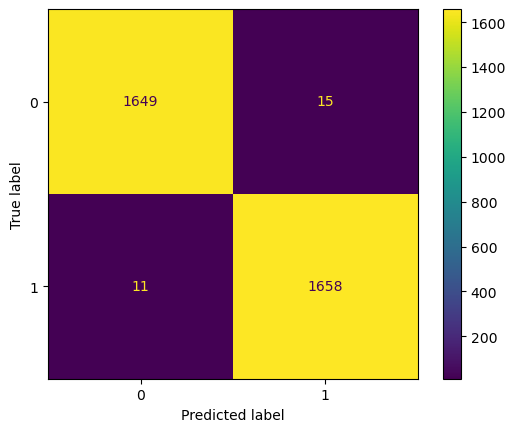

In [44]:
print("Treino")
erros_treino_lSvm = np.round(np.sum(y_treino != lSvm_y_treino_e), 3)
precisao_treino_lSvm = np.round(accuracy_score(y_treino,lSvm_y_treino_e), 3)
matriz_confusao = confusion_matrix(y_treino, lSvm_y_treino_e)
tn_treino_lSvm, fp_treino_lSvm, fn_treino_lSvm, tp_treino_lSvm = matriz_confusao.ravel()

tpr_treino_lSvm = tp_treino_lSvm/(tp_treino_lSvm + fp_treino_lSvm)
fpr_treino_lSvm = fp_treino_lSvm/(fp_treino_lSvm + tn_treino_lSvm)

print("Número de erros:", erros_treino_lSvm)
print("Precisão: ", precisao_treino_lSvm)

disp = ConfusionMatrixDisplay(matriz_confusao)
disp.plot()
plt.show()

Teste
Número de erros: 226
Precisão:  0.864


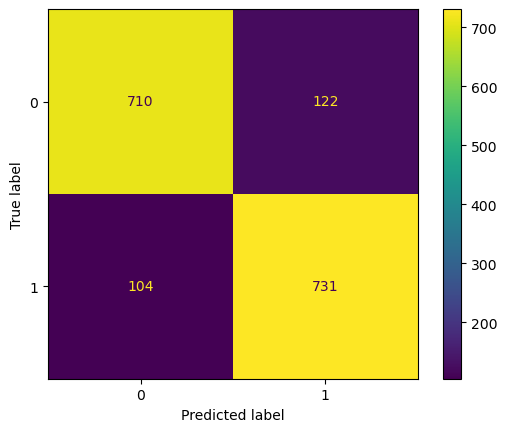

In [45]:
print("Teste")
erros_teste_lSvm = np.round(np.sum(y_teste != lSvm_y_teste_e), 3)
precisao_teste_lSvm = np.round(accuracy_score(y_teste,lSvm_y_teste_e), 3)
matriz_confusao = confusion_matrix(y_teste, lSvm_y_teste_e)
tn_teste_lSvm, fp_teste_lSvm, fn_teste_lSvm, tp_teste_lSvm = matriz_confusao.ravel()

print("Número de erros:", erros_teste_lSvm)
print("Precisão: ", precisao_teste_lSvm)

tpr_teste_lSvm = tp_teste_lSvm/(tp_teste_lSvm + fp_teste_lSvm)
fpr_teste_lSvm = fp_teste_lSvm/(fp_teste_lSvm + tn_teste_lSvm)

disp = ConfusionMatrixDisplay(matriz_confusao)
disp.plot()
plt.show()

# Classificador SVC

- Resultados sem parametrização do classificador

In [22]:
scores = cross_val_score(SVC(max_iter=5000), corpus_treino_p, y_treino, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.85


- Ajuste dos parametros

In [23]:
param_grid = {'C': [0.1, 1, 10, 100],
            'decision_function_shape': ['ovr', 'ovo'],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': [0.001, 0.01, 0.1, 1, 10], 
            'degree': [1, 2, 3]}

grid = GridSearchCV(SVC(max_iter=5000, random_state=42), param_grid, cv=3, verbose=3, n_jobs=-1)
grid.fit(corpus_validacao_p, y_validacao)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


GridSearchCV(cv=3, estimator=SVC(max_iter=5000, random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100],
                         'decision_function_shape': ['ovr', 'ovo'],
                         'degree': [1, 2, 3],
                         'gamma': [0.001, 0.01, 0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             verbose=3)

In [24]:
print(grid.best_estimator_)

SVC(C=10, degree=1, gamma=1, max_iter=5000, random_state=42)


- Treino

In [25]:
svm = SVC(C=0.1, degree=1, gamma=10, kernel='poly', max_iter=5000, random_state=42).fit(corpus_treino_p, y_treino)

svm_y_treino_e = svm.predict(corpus_treino_p)
print("Score treino:", svm.score(corpus_treino_p, y_treino))

Score treino: 0.9921992199219922


- Teste e Avaliação

In [26]:
svm_fpr, svm_tpr, _ = roc_curve(y_teste, svm.decision_function(corpus_teste_p))

svm_y_teste_e = svm.predict(corpus_teste_p)

Treino
Número de erros: 26
Precisão:  0.992


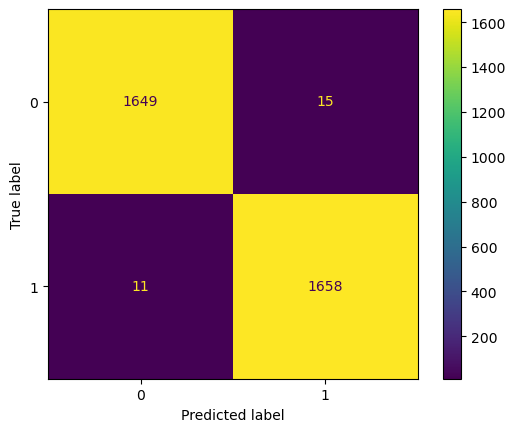

In [48]:
print("Treino")
erros_treino_svm = np.round(np.sum(y_treino != svm_y_treino_e), 3)
precisao_treino_svm = np.round(accuracy_score(y_treino,svm_y_treino_e), 3)
matriz_confusao = confusion_matrix(y_treino, svm_y_treino_e)
tn_treino_svm, fp_treino_svm, fn_treino_svm, tp_treino_svm = matriz_confusao.ravel()

tpr_treino_svm = tp_treino_svm/(tp_treino_svm + fp_treino_svm)
fpr_treino_svm = fp_treino_svm/(fp_treino_svm + tn_treino_svm)

print("Número de erros:", erros_treino_svm)
print("Precisão: ", precisao_treino_svm)

disp = ConfusionMatrixDisplay(matriz_confusao)
disp.plot()
plt.show()

Teste
Número de erros: 226
Precisão:  0.864


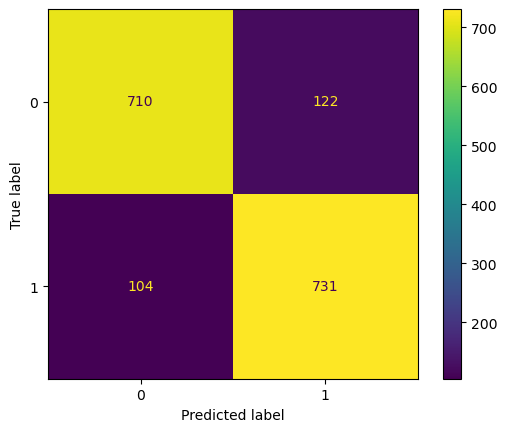

In [51]:
print("Teste")
erros_teste_svm = np.round(np.sum(y_teste != svm_y_teste_e), 3)
precisao_teste_svm = np.round(accuracy_score(y_teste,svm_y_teste_e), 3)
matriz_confusao = confusion_matrix(y_teste, svm_y_teste_e)
tn_teste_svm, fp_teste_svm, fn_teste_svm, tp_teste_svm = matriz_confusao.ravel()

tpr_teste_svm = tp_teste_svm/(tp_teste_svm + fp_teste_svm)
fpr_teste_svm = fp_teste_svm/(fp_teste_svm + tn_teste_svm)

print("Número de erros:", erros_teste_svm)
print("Precisão: ", precisao_teste_svm)

disp = ConfusionMatrixDisplay(matriz_confusao)
disp.plot()
plt.show()

# Classificador NaiveBayes (MultinomialNB)

- Resultados sem parametrização do classificador

In [29]:
scores = cross_val_score(MultinomialNB(), corpus_treino_p, y_treino, cv=5)
print("Mean cross-validation accuracy: {:.2f}".format(np.mean(scores)))

Mean cross-validation accuracy: 0.86


- Ajuste dos parametros

In [30]:
param_grid = {'alpha': [0.1, 0.2, 0.5, 0.8, 0.9]}

grid = GridSearchCV(MultinomialNB(), param_grid, cv=3, verbose=3)
grid.fit(corpus_validacao_p, y_validacao)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END .........................alpha=0.1;, score=0.847 total time=   0.0s
[CV 2/3] END .........................alpha=0.1;, score=0.806 total time=   0.0s
[CV 3/3] END .........................alpha=0.1;, score=0.832 total time=   0.0s
[CV 1/3] END .........................alpha=0.2;, score=0.862 total time=   0.0s
[CV 2/3] END .........................alpha=0.2;, score=0.818 total time=   0.0s
[CV 3/3] END .........................alpha=0.2;, score=0.849 total time=   0.0s
[CV 1/3] END .........................alpha=0.5;, score=0.856 total time=   0.0s
[CV 2/3] END .........................alpha=0.5;, score=0.838 total time=   0.0s
[CV 3/3] END .........................alpha=0.5;, score=0.861 total time=   0.0s
[CV 1/3] END .........................alpha=0.8;, score=0.851 total time=   0.0s
[CV 2/3] END .........................alpha=0.8;, score=0.842 total time=   0.0s
[CV 3/3] END .........................alpha=0.8;,

GridSearchCV(cv=3, estimator=MultinomialNB(),
             param_grid={'alpha': [0.1, 0.2, 0.5, 0.8, 0.9]}, verbose=3)

In [31]:
print(grid.best_estimator_)

MultinomialNB(alpha=0.5)


- Treino

In [32]:
nb = MultinomialNB(alpha=0.8).fit(corpus_treino_p, y_treino)

nb_y_treino_e = nb.predict(corpus_treino_p)
print("Score treino:", nb.score(corpus_treino_p, y_treino))

Score treino: 0.9738973897389739


- Teste e Avaliação

In [33]:
nb_fpr, nb_tpr, _ = roc_curve(y_teste, nb.predict_proba(corpus_teste_p)[:,1])

nb_y_teste_e = nb.predict(corpus_teste_p)

Treino
Número de erros: 87
Precisão:  0.974


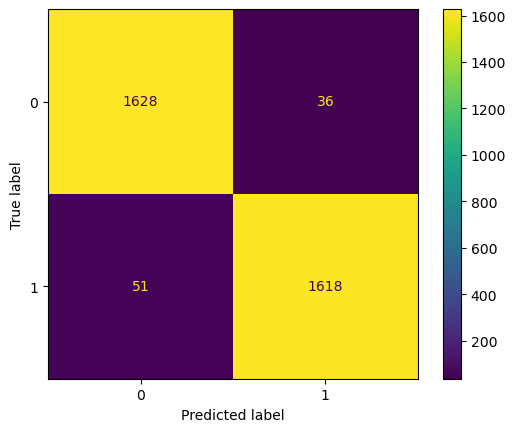

In [52]:
print("Treino")
erros_treino_nb = np.round(np.sum(y_treino != nb_y_treino_e), 3)
precisao_treino_nb = np.round(accuracy_score(y_treino,nb_y_treino_e), 3)
matriz_confusao = confusion_matrix(y_treino, nb_y_treino_e)
tn_treino_nb, fp_treino_nb, fn_treino_nb, tp_treino_nb = matriz_confusao.ravel()

tpr_treino_nb = tp_treino_nb/(tp_treino_nb + fp_treino_nb)
fpr_treino_nb = fp_treino_nb/(fp_treino_nb + tn_treino_nb)

print("Número de erros:", erros_treino_nb)
print("Precisão: ", precisao_treino_nb)

disp = ConfusionMatrixDisplay(matriz_confusao)
disp.plot()
plt.show()

Teste
Número de erros: 245
Precisão:  0.853


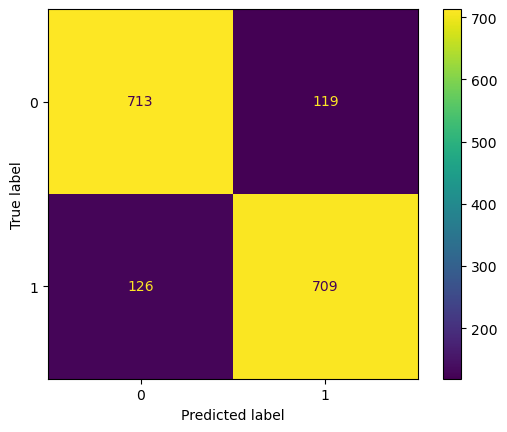

In [54]:
print("Teste")
erros_teste_nb = np.round(np.sum(y_teste != nb_y_teste_e), 3)
precisao_teste_nb = np.round(accuracy_score(y_teste,nb_y_teste_e), 3)
matriz_confusao = confusion_matrix(y_teste, nb_y_teste_e)
tn_teste_nb, fp_teste_nb, fn_teste_nb, tp_teste_nb = matriz_confusao.ravel()

tpr_teste_nb = tp_teste_nb/(tp_teste_nb + fp_teste_nb)
fpr_teste_nb = fp_teste_nb/(fp_teste_nb + tn_teste_nb)

print("Número de erros:", erros_teste_nb)
print("Precisão: ", precisao_teste_nb)

disp = ConfusionMatrixDisplay(matriz_confusao)
disp.plot()
plt.show()

## Comparação dos Classificadores

In [36]:
print("Resultados do Treino: ")
print("\n__LogisticRegression: ")
print("* Número de Erros:", erros_treino_lr, "/", nDocs, "documentos")
print("* Prob. de Erro: ", np.round(erros_treino_lr/nDocs, 3), "%")
print("* Precisão:", precisao_treino_lr)

print("\n__LinearSVC: ")
print("* Número de Erros:", erros_treino_lSvm, "/", nDocs, "documentos")
print("* Prob. de Erro: ", np.round(erros_treino_lSvm/nDocs, 3), "%")
print("* Precisão:", precisao_treino_lSvm)

print("\n__SVC: ")
print("* Número de Erros:", erros_treino_svm, "/", nDocs, "documentos")
print("* Prob. de Erro: ", np.round(erros_treino_svm/nDocs, 3), "%")
print("* Precisão:", precisao_treino_svm)

print("\n__Naive Bayes: ")
print("* Número de Erros:", erros_treino_nb, "/", nDocs, "documentos")
print("* Prob. de Erro: ", np.round(erros_treino_nb/nDocs, 3), "%")
print("* Precisão:", precisao_treino_nb)

Resultados do Treino: 

__LogisticRegression: 
* Número de Erros: 0 / 5000 documentos
* Prob. de Erro:  0.0 %
* Precisão: 1.0

__LinearSVC: 
* Número de Erros: 26 / 5000 documentos
* Prob. de Erro:  0.005 %
* Precisão: 0.992

__SVC: 
* Número de Erros: 26 / 5000 documentos
* Prob. de Erro:  0.005 %
* Precisão: 0.992

__Naive Bayes: 
* Número de Erros: 87 / 5000 documentos
* Prob. de Erro:  0.017 %
* Precisão: 0.974


In [37]:
print("Resultados do Teste: ")
print("\n__LogisticRegression: ")
print("* Número de Erros:", erros_teste_lr, "/", nDocs, "documentos")
print("* Prob. de Erro: ", np.round(erros_teste_lr/nDocs, 3), "%")
print("* Precisão:", precisao_teste_lr)

print("\n__LinearSVC: ")
print("* Número de Erros:", erros_teste_lSvm, "/", nDocs, "documentos")
print("* Prob. de Erro: ", np.round(erros_teste_lSvm/nDocs, 3), "%")
print("* Precisão:", precisao_teste_lSvm)

print("\n__SVC: ")
print("* Número de Erros:", erros_teste_svm, "/", nDocs, "documentos")
print("* Prob. de Erro: ", np.round(erros_teste_svm/nDocs, 3), "%")
print("* Precisão:", precisao_teste_svm)

print("\n__Naive Bayes: ")
print("* Número de Erros:", erros_teste_nb, "/", nDocs, "documentos")
print("* Prob. de Erro: ", np.round(erros_teste_nb/nDocs, 3), "%")
print("* Precisão:", precisao_teste_nb)

Resultados do Teste: 

__LogisticRegression: 
* Número de Erros: 259 / 5000 documentos
* Prob. de Erro:  0.052 %
* Precisão: 0.845

__LinearSVC: 
* Número de Erros: 226 / 5000 documentos
* Prob. de Erro:  0.045 %
* Precisão: 0.864

__SVC: 
* Número de Erros: 226 / 5000 documentos
* Prob. de Erro:  0.045 %
* Precisão: 0.864

__Naive Bayes: 
* Número de Erros: 245 / 5000 documentos
* Prob. de Erro:  0.049 %
* Precisão: 0.853


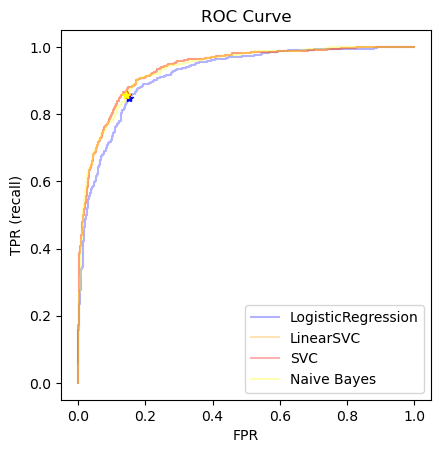

In [40]:
plt.figure()
plt.title("ROC Curve")
plt.plot(lr_fpr, lr_tpr, label="LogisticRegression", color='blue', alpha=0.3)
plt.plot(fpr_teste_lr, tpr_teste_lr, "*", color='blue')
plt.plot(lSvm_fpr, lSvm_tpr, label="LinearSVC", color='orange', alpha=0.3)
plt.plot(fpr_teste_lSvm, tpr_teste_lSvm, "*", color='orange')
plt.plot(svm_fpr, svm_tpr, label="SVC", color='red', alpha=0.3)
plt.plot(fpr_teste_svm, tpr_teste_svm, "*", color='red')
plt.plot(nb_fpr, nb_tpr, label="Naive Bayes", color='yellow', alpha=0.3)
plt.plot(fpr_teste_nb, tpr_teste_nb, "*", color='yellow')
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.axis('scaled')
plt.legend()